# Leer archivos almacenados

In [2]:
#usefull
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#netCDF4
import netCDF4 as nc
import xarray as xr
#GIS
import rasterio as rio
#leer carpetas
import os
#eliminar advertencias innecesarias
import warnings
warnings.filterwarnings('ignore')

In [3]:
# folder path
dir_fold = 'C:/Users/carlo/OneDrive - Universidad Nacional de Colombia/Semestre 11/MachineLearning/DownScaling/VariablesListas'

# list to store Folders
folder = []

# Iterate directory
for path in os.listdir(dir_fold):
    # check if current path is a file
    #if os.path.isfile(os.path.join(dir_path, path)):
        folder.append(path)

In [4]:
orden = [3,2,6,5,1,0,4]

df = pd.DataFrame()

for i in orden:
    df_i = pd.read_csv(dir_fold+'/'+folder[i])
    df = pd.concat([df, df_i], axis=1)

df.head()

,Ppt_ERA5,Humedad,Temperatura,Presion,Elevación,CoorX,CoorY,Ppt_SIATA
0,5.47598,33.672039,13.844298,802.956631,1781.0,-75.28,6.55,43.023724
1,5.47598,33.672039,14.142333,803.052634,1624.0,-75.27,6.55,38.443913
2,5.47598,33.672039,14.421129,803.128664,1308.0,-75.26,6.55,28.653738
3,5.47598,33.672039,14.675893,803.188920,1188.0,-75.25,6.55,14.130409
4,5.47598,33.672039,14.902739,803.236504,1131.0,-75.24,6.55,11.153187


In [5]:
X = df.drop(['Ppt_SIATA'], axis=1)
X = np.array(X)
y = df['Ppt_SIATA']
y = np.array(y)

keys = df.columns

# 15: Regresión Lineal

La Regresión Lineal (RL) asume que las variables predictoras tienen una distribución Gaussiana y que no son correlacionables, por lo tanto es importante en el análisis de datos explorar estas condiciones. Adicionalmente, hay que tener en cuenta que los modelos de RL son modelos geométricos, es decir que se basan en calcular las distancias entre la predicción y los datos reales, por lo tanto es importante normalizar o estandarizar los datos. 

In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error

Supongamos que estamos interesados en establecer la relación lineal simple entre MEDV y RM:

$MEDV \approx \beta_0 + \beta_1 RM$

En este caso sería posible utilizar la herramienta gráfica del _scatterplot_ de la siguiente manera:

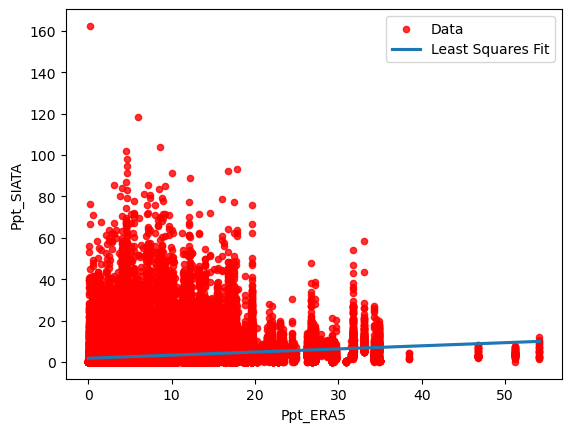

In [7]:
fig, ax = plt.subplots(1,1)
n = 0
sns.regplot(x=X[:,n], y=y, ax=ax, order=1, ci=None, scatter_kws={'color':'r', 's':20})
ax.set_ylabel(keys[-1])
# ax.set_xlim(0,9)
# ax.set_ylim(0,51)
# plt.xscale('log')
# plt.yscale('log')
ax.set_xlabel(keys[n])
ax.legend(['Data','Least Squares Fit']);

Para obtener el mejor ajuste se puede minimizar el residuo de la suma de los cuadrados (Residual Sum of Squares -RSS-):

$\epsilon_i=y_i-\hat{y}_i$

$RSS=\sum_{n=1}^{N} {\epsilon_i}^2$

$\hat\beta_{OLS}=arg min\sum_{n=1}^{N} (y_i-X_i\beta)^2$

Para encontrar la pendiente de esta regresión se puede utilizar:

$\hat\beta_1=\frac{{}\sum_{i=1}^{n}(X_i-\hat{X})(y_i-\hat{y})}{\sum{i=1}^{n}(X_i-\hat{X})^2}$

y el intercepto:

$\hat\beta_0=\hat{y}-\hat\beta_1\hat{X}$

In [8]:
B1_num = ((X[:,n] - X[:,n].mean()) * (y - y.mean())).sum()
B1_den = ((X[:,n] - X[:,n].mean())**2).sum()
B1 = B1_num / B1_den
B0 = y.mean() - (B1*X[:,n].mean()) 
print(B0)
print(B1)

1.7713779493359885
0.1506091204129054


Tambien puede estimarse de su forma matricial:

$\hat\beta_{OLS}=(X'X)^-1(X'y)$

In [9]:
x_ols=X[:,n].reshape(-1, 1)
y_ols=y.T
B1 = np.dot(np.linalg.inv(np.dot(x_ols.T,x_ols)),np.dot(x_ols.T,y_ols))
print(B1)

[0.28996437]


Por qué dieron diferente ambos resultados?

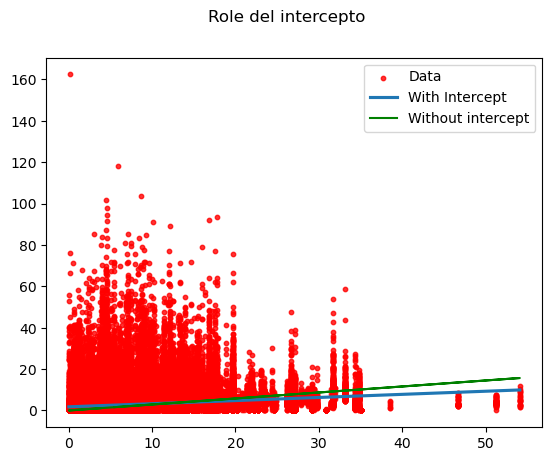

In [10]:
fig, ax = plt.subplots(1,1)
fig.suptitle('Role del intercepto')
sns.regplot(x=X[:,n], y=y, ax=ax, order=1, ci=None, scatter_kws={'color':'r', 's':10})
ax.plot(X[:,n], B1*X[:,n], color='g')
#plt.xlim(0,10); plt.ylim(ymin=0);
ax.legend(['Data','With Intercept', 'Without intercept']);

In [11]:
# How to insert intercept? Add constant: column of ones
one = np.ones(np.shape(X[:,5]))
X1 = np.column_stack([one,X[:,5]])
B1 = np.dot(np.linalg.inv(np.dot(X1.T,X1)),np.dot(X1.T,y_ols))
print(B1)

[-32.62762934  -0.46993717]


Para calcular el coeficiente de determinación $R^2$ y el coeficiente de correlación $R$ se puede utilizar el coeficiente de correlación de Pearson:

$\rho = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}$

$r = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
	{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}$

In [12]:
N = len(X[:,n])
num = (N * (X[:,n]*y).sum()) - (X[:,n].sum() * y.sum())
den = np.sqrt((N * (X[:,n]**2).sum() - X[:,n].sum()**2) * (N * (y**2).sum() - y.sum()**2))
R = num / den
print("R: ",R)
print("R2: ",np.sqrt(R))

R:  0.160707492952315
R2:  0.4008833907164464


Para calcular el RSS se puede utilizar:

In [13]:
from sklearn.preprocessing import scale

# First, scale the data
Xn = scale(X[:,n], with_mean=True, with_std=False).reshape(-1,1)
regr = LinearRegression().fit(Xn,y)

# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-5, regr.intercept_+5, 50)
B1 = np.linspace(regr.coef_-0.1, regr.coef_+0.1, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+Xn.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*Xn - y.reshape(-1,1))**2)/1000
min_rss

4076.8306750002394

In [14]:
prediction=regr.predict(Xn.reshape(-1,1))
residual=(y-prediction)
RSS=sum(residual**2)
print(RSS)

4076830.6750002755


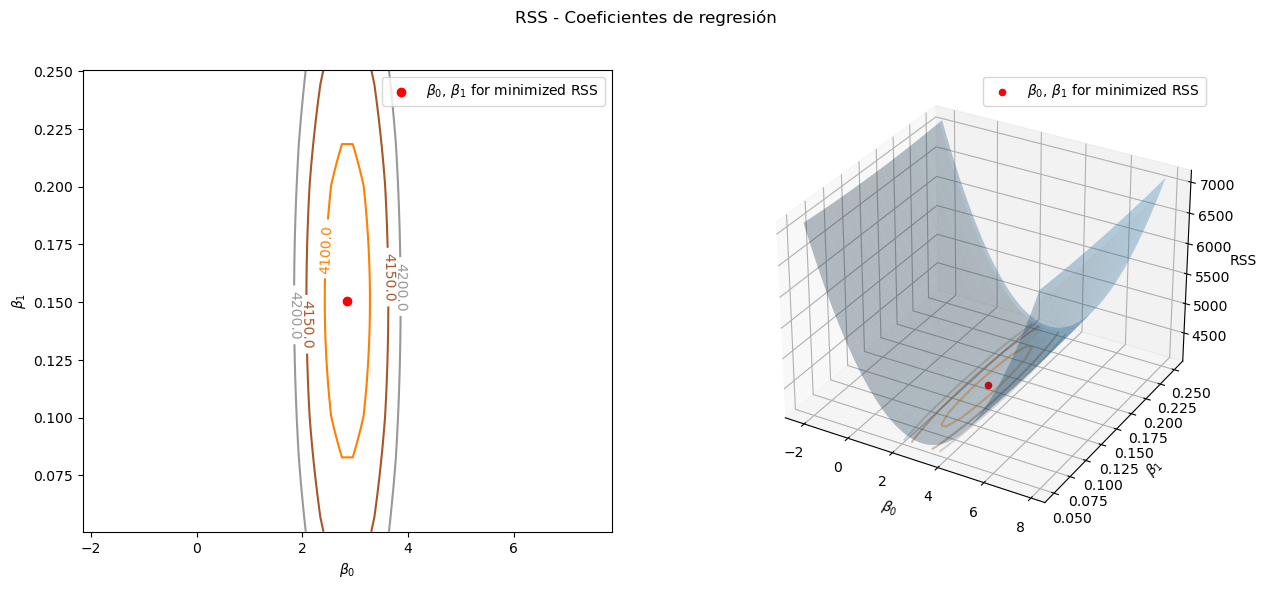

In [15]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Coeficientes de regresión')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[4000,4050,4100,4150,4200])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[4000,4050,4100,4150,4200])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
#ax2.set_ylim(9,9.2)


# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$')
    ax.set_ylabel(r'$\beta_1$')
    ax.legend()

## Método OLS de la librería *statsmodels*

Aunque la librería mas completa para *machine learning* en Python es Sklearn, existen otras librerías con funciones interesantes, un ejemplo es la librería *statsmodels*. Esta librería permite para los modelos RL obtener un resumen de la implementación del modelo muy útil. A continuación se detalla.

Se importa la librearía como *sm*. Para su implementación, a diferencia de Sklearn, se entrena y posteriormente se aplica la función *fit*. 

Finalmente, podemos imprimir con la función *summary* el resultado de la implementación, con métricas muy importantes que permiten conocer el ajuste a los datos.

In [16]:
import statsmodels.api as sm
lm=sm.OLS(y, X).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.219
Model:                            OLS   Adj. R-squared (uncentered):              0.219
Method:                 Least Squares   F-statistic:                              4806.
Date:                Thu, 08 Dec 2022   Prob (F-statistic):                        0.00
Time:                        11:48:21   Log-Likelihood:                     -3.8129e+05
No. Observations:              120048   AIC:                                  7.626e+05
Df Residuals:                  120041   BIC:                                  7.627e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Modelo de regresión multivariado

In [17]:
X = df.drop(['Ppt_SIATA'], axis=1)
y = df['Ppt_SIATA']

keys = df.columns

df.head(2)

,Ppt_ERA5,Humedad,Temperatura,Presion,Elevación,CoorX,CoorY,Ppt_SIATA
0,5.47598,33.672039,13.844298,802.956631,1781.0,-75.28,6.55,43.023724
1,5.47598,33.672039,14.142333,803.052634,1624.0,-75.27,6.55,38.443913


In [18]:
lm=sm.OLS(y, X).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:              Ppt_SIATA   R-squared (uncentered):                   0.219
Model:                            OLS   Adj. R-squared (uncentered):              0.219
Method:                 Least Squares   F-statistic:                              4806.
Date:                Thu, 08 Dec 2022   Prob (F-statistic):                        0.00
Time:                        11:48:22   Log-Likelihood:                     -3.8129e+05
No. Observations:              120048   AIC:                                  7.626e+05
Df Residuals:                  120041   BIC:                                  7.627e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

La librearía _statsmodels_ permite utilizar la sintásis [Pasty](https://patsy.readthedocs.io/en/latest/index.html) de la siguiente forma:

In [19]:
#Con intercepto
import statsmodels.formula.api as smf
lm=smf.ols(formula='Ppt_SIATA ~ Ppt_ERA5 + Humedad + Temperatura + Elevación', data=df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              Ppt_SIATA   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1092.
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:48:22   Log-Likelihood:            -3.8136e+05
No. Observations:              120048   AIC:                         7.627e+05
Df Residuals:                  120043   BIC:                         7.628e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.7144      0.219     35.263      

In [20]:
#Para eliminar intercepto
import statsmodels.formula.api as smf
lm=smf.ols(formula='Ppt_SIATA ~ Ppt_ERA5 + Humedad + Temperatura + Elevación + CoorX + CoorY - 1', data=df).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:              Ppt_SIATA   R-squared (uncentered):                   0.219
Model:                            OLS   Adj. R-squared (uncentered):              0.219
Method:                 Least Squares   F-statistic:                              5607.
Date:                Thu, 08 Dec 2022   Prob (F-statistic):                        0.00
Time:                        11:48:37   Log-Likelihood:                     -3.8129e+05
No. Observations:              120048   AIC:                                  7.626e+05
Df Residuals:                  120042   BIC:                                  7.626e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

# Interpretation

*Dep. Variable*: Here dependent variable is price that we are going to predict through model.

*Model*: OLS stands for Ordinary Least Squares. Ordinary least squares (OLS) is a type of linear least squares method for estimating the unknown parameters in a linear regression model. OLS selects the parameters of a linear function of a set of explanatory variables by the principle of least squares.

*Method*: Least squares is a standard approach in regression analysis to approximate the solution by minimising the sum of the squares of the residuals.

*No of Observations*: Total no of observations present in dataset.

*Df Residuals*: The df(Residual) is the sample size minus the number of parameters being estimated, so it becomes df(Residual) = n — (k+1).

*R-Squared*: R2 is a statistic that will give some information about the goodness of fit of a model. It ranges from 0 to 1.

*Adj. R Squared*: Each time you add an independent variable to the model, the R-squared increases, even if the independent variable is not significant. It never decreases. Whereas Adjusted R-squared increases only when the independent variable is significant and affects the dependent variable. Adjusted R-square should be used while selecting important predictors (independent variables) for the regression model.

*F-statistics and Prob F-statistics*: The “F value’’ and “Prob(F)’’ statistics test the overall significance of the regression model. Specifically, they test the null hypothesis that all of the regression coefficients are equal to zero.The F value is the ratio of the mean regression sum of squares divided by the mean error sum of squares. Its value will range from zero to an arbitrarily large number. The value of Prob(F) is the probability that the null hypothesis for the full model is true (i.e., that all of the regression coefficients are zero). For example, if Prob(F) has a value of 8.13e-31 then there is almost zero chance in 100 that all of the regression parameters are zero.

*AIC & BIC*: AIC is abbreviation for Akaike’s Information Criteria and is used for model selection. It penalizes the errors mode in case a new variable is added to the regression equation. It is calculated as the number of parameters minus the likelihood of the overall model. A lower AIC implies a better model. Whereas, BIC stands for Bayesian information criteria and is a variant of AIC where penalties are made more severe.

*coef*: Here we have coefficient for const and weights.

*std err*: It shows accuracy for each prediction. Lower the std error better the estimates.

*t & p(t)*: It shows value for t statistics and p value. It involves hypothesis. It answers question as Is it a useful variable or does it help us to explain variability we have in this case. As we know p value </0.05 is considered as variable significant.

*Omnibus/Prob(Omnibus)*: Omnibus test is carried out in order to check whether errors are normally distributed(one of the assumptions of linear regression). Here, the null hypothesis is that the errors are normally distributed. A value close to zero is preferred, that would indicate normality. The Prob (Omnibus) performs a statistical test showing the probability that the residuals are normally distributed. A value close to 1 is preferred here.

*Skew*: Value of Skew is preferred close to zero, indicating the residual distribution is normal. Note that this value also controls the Omnibus.

*Kurtosis*: It is a measure of curvature (peakiness)of the data. Higher peaks lead to greater Kurtosis. Higher value for Kurtosis shows tighter clustering of residuals around zero, implying a better model with few outliers.

*Durbin-Watson*: It tests for homoscedasticity (independance of error). A value between 1 and 2 is preferred.

*Jarque-Bera (JB)/Prob(JB)*: This test is for normality of residual(one of the assumption for linear regression)The test is named after Carlos Jarque and Anil K. Bera. The test statistic is always positive. A large value of Jarque-Bera test shows that the errors are not normally distributed.

*Condition Number*: This test measures the sensitivity of a function’s output as compared to its input. In case of multicollinearity, we can expect much higher fluctuations to small changes in the data.


## Transformación de variables

In [ ]:
df.head(2)

,Ppt_ERA5,Humedad,Temperatura,Presion,Elevación,CoorX,CoorY,Ppt_SIATA
0,5.47598,33.672039,13.844298,802.956631,1781.0,-75.28,6.55,43.023724
1,5.47598,33.672039,14.142333,803.052634,1624.0,-75.27,6.55,38.443913


Los modelos de regresión permiten tranformar variables para mejorar el ajuste o para cumplir con los asumpsiones de la regresión. Por ejmplor es posible cosntruir un modelo de la siguiente forma:

Rainfall ~ $\beta_0 + \beta_1Sunshine + \beta_2Evaporation + \beta_3Pressure9am*Pressure3pm$

In [ ]:
lm=sm.OLS.from_formula("Ppt_SIATA ~ Ppt_ERA5 + Temperatura + Elevación + Humedad/Temperatura -1", df).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:              Ppt_SIATA   R-squared (uncentered):                   0.217
Model:                            OLS   Adj. R-squared (uncentered):              0.217
Method:                 Least Squares   F-statistic:                              6666.
Date:                Thu, 08 Dec 2022   Prob (F-statistic):                        0.00
Time:                        03:16:16   Log-Likelihood:                     -3.8141e+05
No. Observations:              120048   AIC:                                  7.628e+05
Df Residuals:                  120043   BIC:                                  7.629e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Un tipo de transformación común realizado en regresiones para ajustar una variable a un distribución normal es la transformación logarítmica. En este caso se puede realizar de la siguiente manera:

In [ ]:
lm=sm.OLS.from_formula("Ppt_SIATA ~  Humedad + Temperatura + Elevación + Humedad/Temperatura + np.log(Ppt_ERA5) - 1", df).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:              Ppt_SIATA   R-squared (uncentered):                   0.215
Model:                            OLS   Adj. R-squared (uncentered):              0.215
Method:                 Least Squares   F-statistic:                              6578.
Date:                Thu, 08 Dec 2022   Prob (F-statistic):                        0.00
Time:                        01:14:14   Log-Likelihood:                     -3.8158e+05
No. Observations:              120048   AIC:                                  7.632e+05
Df Residuals:                  120043   BIC:                                  7.632e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Un caso especial de transformación es la denominada _Box-Cox_ λ. Este tipo de trasnformación se debe realizar previamente de la siguiente manera:

In [ ]:
from scipy import stats
transformed_price, lambda_price = stats.boxcox(df['Presion'])
print(transformed_price)
print(lambda_price)

[1.32472127e+13 1.32547386e+13 1.32607012e+13 ... 1.45491725e+13
 1.45491725e+13 1.45491725e+13]
4.750544100134097


In [ ]:
df["transformed_price"]=transformed_price
lm=sm.OLS.from_formula("Ppt_SIATA ~ Ppt_ERA5 + Temperatura + np.log(Elevación)+ transformed_price", df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              Ppt_SIATA   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1078.
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        01:14:14   Log-Likelihood:            -3.8139e+05
No. Observations:              120048   AIC:                         7.628e+05
Df Residuals:                  120043   BIC:                         7.628e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.3343      0.65

Los modelos de regresión lineal permiten incluso incorporar relaciones no lineales de sus variables, de la siguiente forma:

In [ ]:
lm=sm.OLS.from_formula("Ppt_SIATA ~ Ppt_ERA5 + Temperatura + I(Elevación**2) - 1", df).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:              Ppt_SIATA   R-squared (uncentered):                   0.206
Model:                            OLS   Adj. R-squared (uncentered):              0.206
Method:                 Least Squares   F-statistic:                          1.038e+04
Date:                Thu, 08 Dec 2022   Prob (F-statistic):                        0.00
Time:                        01:14:14   Log-Likelihood:                     -3.8227e+05
No. Observations:              120048   AIC:                                  7.646e+05
Df Residuals:                  120045   BIC:                                  7.646e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## Evaluación de la regresión

In [21]:
orden = [3,2,6,5,1,0,4]

df = pd.DataFrame()

for i in orden:
    df_i = pd.read_csv(dir_fold+'/'+folder[i])
    df = pd.concat([df, df_i], axis=1)

X = df.drop(['Ppt_SIATA'], axis=1)
X = np.array(X)
y = df['Ppt_SIATA']
y = np.array(y)

keys = df.columns

df.head(2)

,Ppt_ERA5,Humedad,Temperatura,Presion,Elevación,CoorX,CoorY,Ppt_SIATA
0,5.47598,33.672039,13.844298,802.956631,1781.0,-75.28,6.55,43.023724
1,5.47598,33.672039,14.142333,803.052634,1624.0,-75.27,6.55,38.443913


Es posible obtener los valores de Y con el modelo entrenado, utilizando los datos de entrenamiento y los datos de validación. Ademas se puede comparar visualmente el ajuste con los datos reales de validación y las predicciones con los datos de validación.

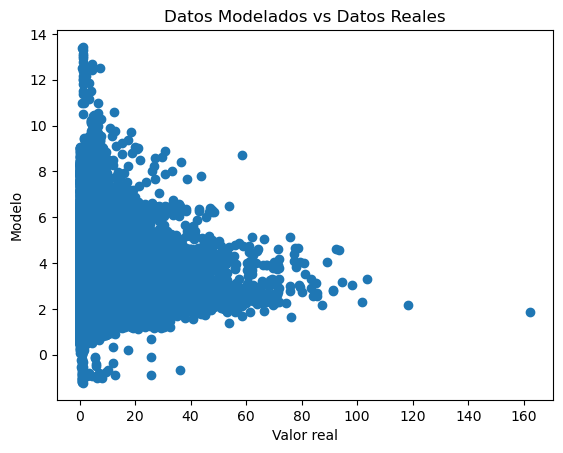

In [22]:
lm=sm.OLS(y, X).fit()
y_pred=lm.predict(X)
y_test_pred=lm.predict(X)
plt.scatter(y,y_pred)
plt.title('Datos Modelados vs Datos Reales')
plt.xlabel('Valor real')
plt.ylabel('Modelo');

El error residual, es decir la diferencia entre los datos de predicción y las variables predictoras, se distribuye de la siguiente manera para este ejemplo.

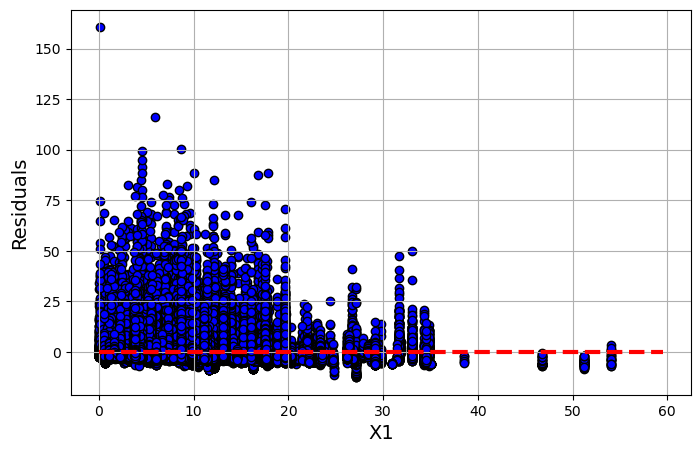

In [23]:
plt.figure(figsize=(8,5))
plt.scatter(x=X[:,0],y=lm.resid,color='blue',edgecolor='k')
plt.grid(True)
xmin=min(X[:,0])
xmax = max(X[:,0])
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.ylabel('Residuals',fontsize=14)
plt.xlabel('X1',fontsize=14)
plt.show()

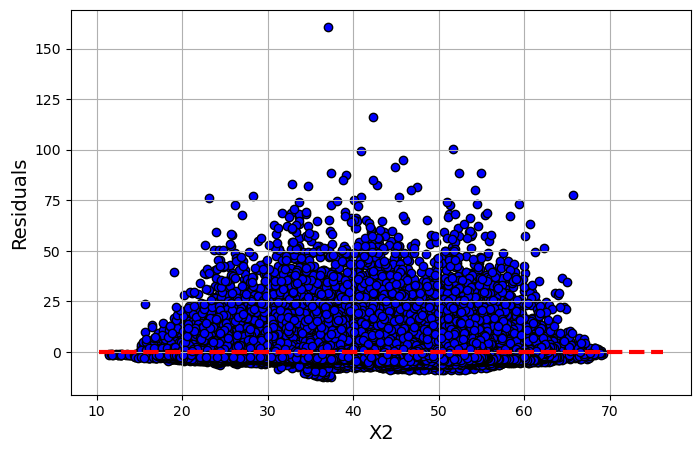

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(x=X[:,1],y=lm.resid,color='blue',edgecolor='k')
plt.grid(True)
xmin=min(X[:,1])
xmax = max(X[:,1])
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.ylabel('Residuals',fontsize=14)
plt.xlabel('X2',fontsize=14)
plt.show()

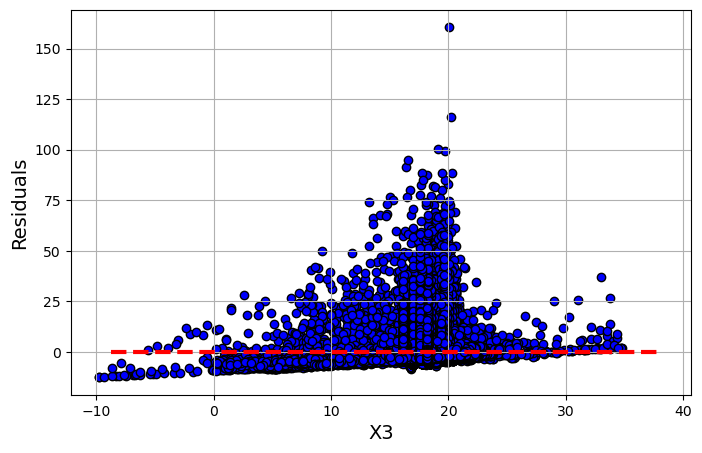

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(x=X[:,2],y=lm.resid,color='blue',edgecolor='k')
plt.grid(True)
xmin=min(X[:,2])
xmax = max(X[:,2])
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.ylabel('Residuals',fontsize=14)
plt.xlabel('X3',fontsize=14)
plt.show()

Residual plots show some bit of clustering but overall the assumptions linearity and independence seem to hold because the distribution seem random around the 0 axis.

## Fitted vs. residuals

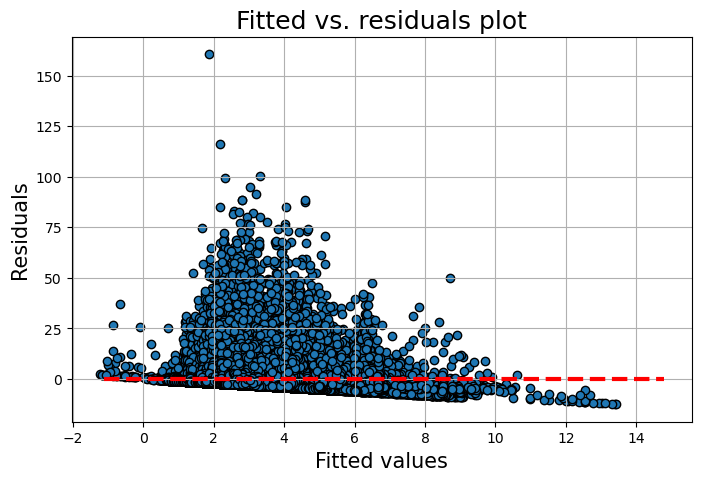

In [ ]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=lm.fittedvalues,y=lm.resid,edgecolor='k')
xmin=min(lm.fittedvalues)
xmax = max(lm.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

## Histogram of normalized residuals

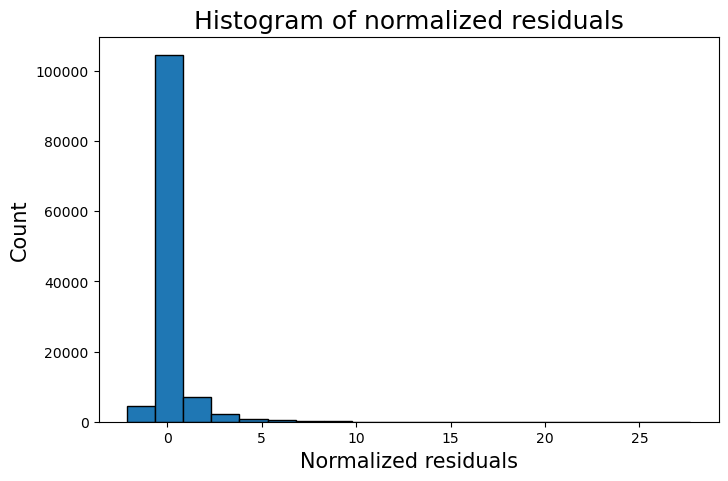

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(lm.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

## Q-Q plot of the residuals

<Figure size 800x500 with 0 Axes>

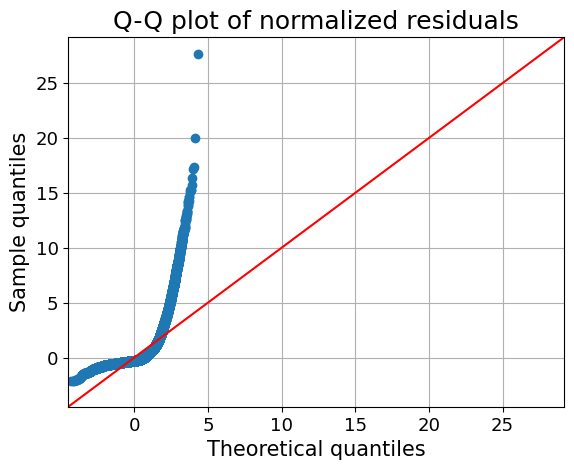

In [ ]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(8,5))
fig=qqplot(lm.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import shapiro
_,p=shapiro(lm.resid)
if p<0.01:
    print("The residuals seem to come from Gaussian process")
else:
    print("The normality assumption may not hold")

The residuals seem to come from Gaussian process


## Cook's distance (checking for outliers in residuals)

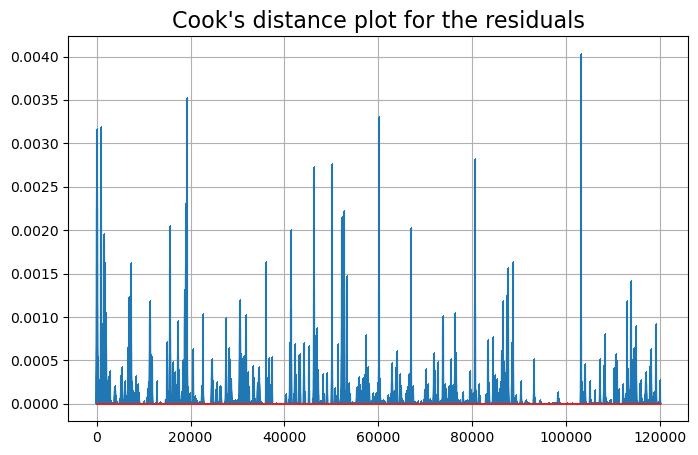

In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence
inf=influence(lm)
(c, p) = inf.cooks_distance
plt.figure(figsize=(8,5))
plt.title("Cook's distance plot for the residuals",fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.grid(True)
plt.show()

## Variance inflation factor

In [ ]:
keys

Index(['Ppt_ERA5', 'Humedad', 'Temperatura', 'Presion', 'Elevación', 'CoorX',
       'CoorY', 'Ppt_SIATA'],
      dtype='object')

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
for i in range(len(X[0])):
    v=vif(np.matrix(X),i)
    print("Variance inflation factor for x{}: {}".format([i+1],round(v,2)))


Variance inflation factor for x[1]: 2.57
Variance inflation factor for x[2]: 18.47
Variance inflation factor for x[3]: 112.88
Variance inflation factor for x[4]: 762.17
Variance inflation factor for x[5]: 26.95
Variance inflation factor for x[6]: 3634.11
Variance inflation factor for x[7]: 2595.9


There are several features with VIF > 10, thereby indicating significant multicollinearity

## Métricas

Separamos en datos de entrenamiento y datos de validación con un 30%, y definimos como variables predictoras *X*, y variable dependiente *y*.

In [ ]:
orden = [3,2,6,5,1,0,4]

df = pd.DataFrame()

for i in orden:
    df_i = pd.read_csv(dir_fold+'/'+folder[i])
    df = pd.concat([df, df_i], axis=1)

X = df.drop(['Ppt_SIATA'], axis=1)
y = df['Ppt_SIATA']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(X, y, test_size=0.3)

A continuación se calcula algunas métricas utilizadas en los problemas de regresión, tanto para los datos de entrenamiento, como para los datos de validación. Lo cual permite observar si el modelo presenta problemas de *bias* o de *overfitting*.

In [ ]:
y_train_pred=lm.predict(x_train)
y_test_pred=lm.predict(x_test)

In [ ]:
print('TRAIN MAE:', mean_absolute_error(y_train,y_train_pred))
print('TEST MAE:', mean_absolute_error(y_test,y_test_pred))

TRAIN MAE: 3.1692663015998597
TEST MAE: 3.131849906302998


In [ ]:
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))

Train RMSE: 5.870563436469552
Test RMSE: 5.618595336499834


In [ ]:
print('R2 Train:',lm.rsquared)
print('R2 Test:',lm.rsquared)

R2 Train: 0.2189044116354879
R2 Test: 0.2189044116354879


In [ ]:
print('R2 Train:',lm.rsquared_adj)
print('R2 Test:',lm.rsquared_adj)

R2 Train: 0.21885886328851856
R2 Test: 0.21885886328851856


In [ ]:
y_pred_vec = (y_train_pred.append(y_test_pred)).sort_index(axis=0)
y_pred_vec

0         3.700421
1         3.686835
2         3.758365
3         3.739320
4         3.697230
            ...   
120043    3.226054
120044    3.117868
120045    3.145178
120046    3.014766
120047    3.019133
Length: 120048, dtype: float64

In [ ]:
mask  = np.loadtxt('mask_Aburra.asc', skiprows = 6)


y_pred_arr = []

n_dat = len(y)/122 # 122 días, esta operación me da la cantidad de datos por fecha
val_ini = int(len(y_test)%n_dat) # Voto los primeros que no forman una fecha completa
n_arr = int(len(y_test[val_ini:])/n_dat) # Me dice cuantas fechas quedaron contenidas en el test

c = 0
for k in range(122):
    arr_model = mask*0
    for i in range(len(mask)):
        for j in range(len(mask[1])):
            if mask[i][j] == -999:
                arr_model[i][j]=np.nan
            else:
                arr_model[i][j]=y_pred_vec[c]
                c = c+1
    y_pred_arr.append(arr_model)

### Para volver a la representación en mapa

In [ ]:
y_pred_vec.mean()

2.854782569611349

In [ ]:
#Guardar Precipitación SIATA
(pd.DataFrame(zip(y_pred_vec),columns=['Ppt_RegLineal'])).to_csv('Resultados_Ppt/Ppt_RegLineal.csv', index=False)

In [ ]:
y.mean()

2.8547854568424134

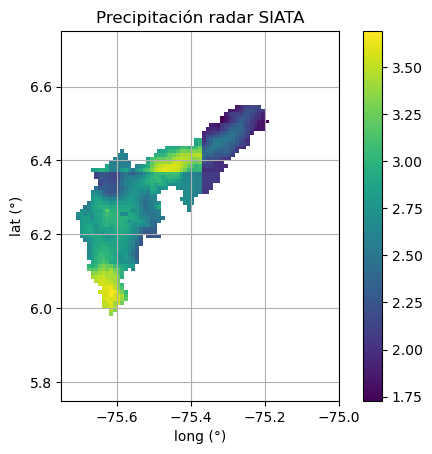

In [ ]:
#Grafico
n = 0
plt.close('chao')
plt.figure('chao')
plt.imshow(y_pred_arr[3], extent=(-75.75,-75, 5.75, 6.75))
plt.ylim(5.75,6.75)
plt.xlim(-75.75,-75)
plt.gca().set_aspect('equal')
plt.title("Precipitación radar SIATA")
plt.colorbar()
plt.xlabel('long (°)')
plt.ylabel('lat (°)')
plt.grid()
plt.show('chao') 

## Regresión Lineal con Sklearn

Para implementar los problemas de RL con Sklearn se utiliza el siguiente procedimiento.

In [ ]:
from sklearn.linear_model import LinearRegression

Se instancia el modelo a utilizar, en este caso *LinearRegression* se ajusta a los datos, y finalmente se aplica a los datos de validación para la predicción y conocer el ajuste. Como resultados se pueden obtener el intercepto y los coeficientes de cada variable predictora.

In [ ]:
model = LinearRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print('Intercepto:',model.intercept_)
print('Coeficientes:',model.coef_)

Intercepto: 13.466795888455103
Coeficientes: [ 1.24867355e-01  1.60408276e-02 -2.95159300e-01  4.62832968e-04
 -5.67971623e-04 -6.75469616e-02 -1.73133782e+00]


Algunas métricas que se pueden implementar desde *Sklearn* son:

In [ ]:
print('R2:',model.score(x_test,y_test))
print('R2:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('MAE:',mean_absolute_error(y_test,y_pred))

R2: 0.034766545571609186
R2: 0.034766545571609186
MSE: 34.29434516707993
MAE: 3.147647874863301


También se puede obtener el ajuste visual.

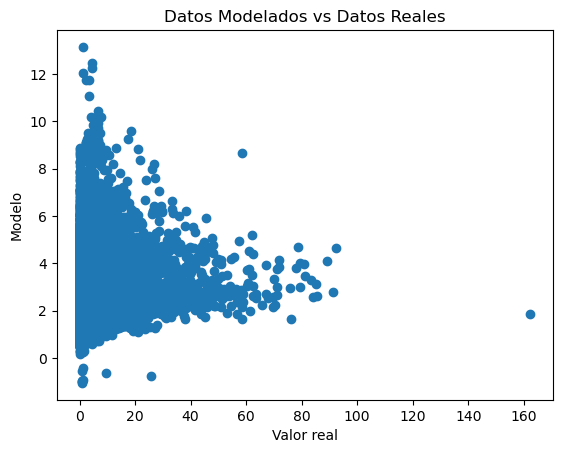

In [ ]:
plt.scatter(y_test,y_pred)
plt.title('Datos Modelados vs Datos Reales')
plt.xlabel('Valor real')
plt.ylabel('Modelo');

Con los datos de entrenamiento se puede implementar el *cross validation* y conocer el ajuste del modelo y su varianza.

In [ ]:
kfold = KFold(n_splits=5, random_state=7, shuffle=True)
results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='r2')
print(results)
print(results.mean())

[0.0340749  0.03566415 0.04006254 0.04024066 0.03542729]
0.037093908273444144


Se obtiene como promedio un valor muy bajo, pero es debido a su gran dispersión. Lo cual se puede observar cuando se modifica el número de *split*.

In [ ]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(results)
print(results.mean())

[0.02691707 0.04053903 0.03842048 0.03827348 0.03824526 0.03427669
 0.03664761 0.03745396 0.03872846 0.03314491]
0.03626469549068646


A continuación se presentan los dos modelos de RL con penalización mas conocidos, denominados Lasso (L1) y Ridge (L2).

# Regularización

Uno de las herramientas para reducir los problemas de *overfitting* se refieren a la regularización. En los siguientes ejemplos vamos a observar la aplicación de los métodos de Ridge y Lasso, y el comportamiento del hiperparámetro Lamba para ambos casos.

Inicialmente importamos las librerías:

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

Vamos a trabajar con la base de datos de Sklearn denominada *boston*.

In [ ]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]
print(X.shape)
print(y.shape)

(506, 13)
(506,)


In [ ]:
lr=LinearRegression()
lr.fit(X, y)
lr_score = lr.score(X,y)
print('Linear regression score:', lr_score)

Linear regression score: 0.7406077428649427


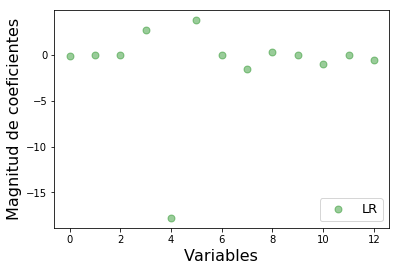

In [ ]:
plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='LR')
plt.xlabel('Variables',fontsize=16)
plt.ylabel('Magnitud de coeficientes',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

In [ ]:
print(lr.coef_)

[-1.07170557e-01  4.63952195e-02  2.08602395e-02  2.68856140e+00
 -1.77957587e+01  3.80475246e+00  7.51061703e-04 -1.47575880e+00
  3.05655038e-01 -1.23293463e-02 -9.53463555e-01  9.39251272e-03
 -5.25466633e-01]


En la figura y matriz anterior se observan los pesos de las 13 variables obtenidas por métodos de regresión linear sin ningún tipo de penalización.

A continuación se implementarán sobre los mismos datos el modelo Ridge y Lasso, los cuales penalizan a traves del hiperparámetro lambda los pesos de cada una de las variables.

### Ridge regression

In [ ]:
rr001 = Ridge(alpha=0.01)
rr001.fit(X, y)
Ridge_score_001 = rr001.score(X,y)
print('Ridge score_001:', Ridge_score_001)

rr = Ridge()
rr.fit(X, y)
Ridge_score = rr.score(X,y)
print('Ridge score_1:', Ridge_score)

rr100 = Ridge(alpha=100)
rr100.fit(X, y)
Ridge_score_100 = rr100.score(X,y)
print('Ridge score_100:', Ridge_score_100)


Ridge score_001: 0.7406072669874482
Ridge score_1: 0.7388294987673955
Ridge score_100: 0.7178124385677699


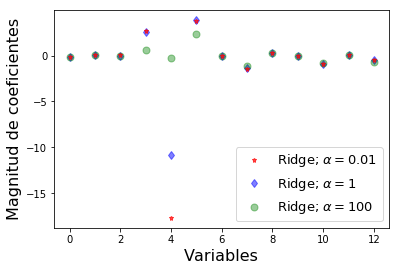

In [ ]:
plt.plot(rr001.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.plot(rr.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 1$') # alpha here is for transparency
plt.plot(rr100.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label=r'Ridge; $\alpha = 100$')
plt.xlabel('Variables',fontsize=16)
plt.ylabel('Magnitud de coeficientes',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

En la figura anterior del modelo Ridge. en el eje X están los índices de los coeficientes, el modelo tiene 13 variables iniciales. Para valores bajos de lambda (0.01), cuando los coeficientes son menos restringidos, la magnitud de los coeficientes es casi similar que para el modelo normal de regresión lineal. Para valores grandes (100), los coeficientes 3, 4 y 5 la magnitud es considerablemente menor comparada al modelo de regresión linear.

A continuación se implementa el modelo *ridge* utilizando la separación simple *train_test* y el *cross validation* para observar la diferencia de resultados entre los coeficientes y el ajuste con la RL normal y *Lasso*. En todos estos casos se utiliza por defecto un valor de *lambda* = 1. Los modelos de RL normal corresponde a cualquiera de los dos métodos, pero con un valor de *lambda*=0. Utilizando la curva de validación se puede obtener el valor óptimo que mejora el ajuste del modelo.

In [ ]:
model = Ridge()

In [ ]:
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print('Intercepto:',model.intercept_)
print('Coeficientes:',model.coef_)
print('R2:',r2_score(y_test,y_pred))

Intercepto: 28.0262752082101
Coeficientes: [-8.97936349e-02  5.79959042e-02 -3.81952780e-02  2.59403049e+00
 -9.74745413e+00  3.90387030e+00 -1.43145582e-02 -1.41260458e+00
  2.35286370e-01 -8.70813283e-03 -7.99505049e-01  1.09316575e-02
 -4.89264002e-01]
R2: 0.7628736799283028


In [ ]:
kfold = KFold(n_splits=5, random_state=1)
results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(results)
print(results.mean())

[ 0.66089569  0.74094893  0.62923672  0.08530169 -0.17029513]
0.38921758241023985


Se observa un mayor ajuste con la separación simple, pero existe una gran varianza en los datos.

### LASSO Regression

Este tipo de regularización (L1) puede reducir completamente la importancia de las variables hasta 0, por lo tanto no solamente se utiliza para reducir el sobreajuste en un modelo, sino ademas como método de selección de variables.. El parémetro por defecto de la regularización Lasso es 1. 

A continuación se implementará el modelo Lasso.

In [ ]:
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X,y)
lasso_score001=lasso001.score(X,y)
coeff_used001 = np.sum(lasso001.coef_!=0)
print ("Lasso score para alpha=0.01 es", lasso_score001) 
print ("Número de variables utilizadas para alpha =0.01:", coeff_used001)
print(lasso001.coef_)

lasso = Lasso()
lasso.fit(X,y)
lasso_score_1=lasso.score(X,y)
coeff_used = np.sum(lasso.coef_!=0)
print ("Lasso score para alpha=1 es", lasso_score_1) 
print ("Número de variables utilizadas para alpha =1: ", coeff_used)
print(lasso.coef_)

lasso100 = Lasso(alpha=100, max_iter=10e5)
lasso100.fit(X,y)
lasso_score100=lasso100.score(X,y)
coeff_used100 = np.sum(lasso100.coef_!=0)
print ("Lasso score para alpha=100 es", lasso_score100) 
print ("Número de variables utilizadas para alpha =100:", coeff_used100)
print(lasso100.coef_)

Lasso score para alpha=0.01 es 0.7401747367311462
Número de variables utilizadas para alpha =0.01: 13
[-1.05330983e-01  4.68329072e-02  6.77570009e-03  2.50607938e+00
 -1.44226291e+01  3.80918476e+00 -1.76057409e-03 -1.42229358e+00
  2.98099885e-01 -1.26220655e-02 -9.17066833e-01  9.56558992e-03
 -5.31194326e-01]
Lasso score para alpha=1 es 0.6825494617506651
Número de variables utilizadas para alpha =1:  10
[-0.06342255  0.04916867 -0.          0.         -0.          0.94678567
  0.02092737 -0.66900864  0.26417501 -0.01520915 -0.72319901  0.00829117
 -0.76143296]
Lasso score para alpha=100 es 0.22497922550751603
Número de variables utilizadas para alpha =100: 2
[-0.          0.         -0.          0.         -0.          0.
 -0.          0.         -0.         -0.02097192 -0.          0.00446643
 -0.        ]


En el caso anterior, cuando se incrementa el valor de lambda a 100, los pesos de los parámetros se reducen de tal forma que solo dos variables (11 y 12) permanecen con valores ligéramente diferentes a 0.

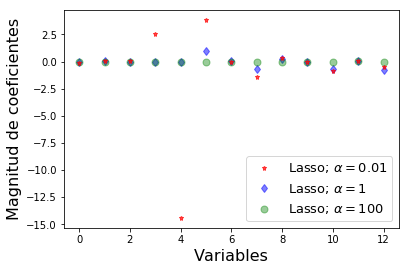

In [ ]:
plt.plot(lasso001.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.plot(lasso.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 1$') # alpha here is for transparency
plt.plot(lasso100.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label=r'Lasso; $\alpha = 100$')
plt.xlabel('Variables',fontsize=16)
plt.ylabel('Magnitud de coeficientes',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

De forma similar se implementa el RL tipo *lasso*.

In [ ]:
from sklearn.linear_model import Lasso
model = Lasso()

In [ ]:
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print('Intercepto:',model.intercept_)
print('Coeficientes:',model.coef_)
print('R2:',r2_score(y_test,y_pred))

Intercepto: 38.202168185895495
Coeficientes: [-0.03790178  0.0608616  -0.0045888   0.         -0.          1.007868
  0.01097365 -0.78931757  0.21562959 -0.0116075  -0.63992023  0.00979854
 -0.73309521]
R2: 0.715480373563341


In [ ]:
kfold = KFold(n_splits=5, random_state=1)
results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(results)
print(results.mean())

[0.56156843 0.63385562 0.33456629 0.35466066 0.27459294]
0.431848787926522


Similares resultados en términos de varianza para el modelo *lasso*, sin embargo se observa un valor mayor de ajuste para la *cross validation*. en este aso es muy importante elaborar la curva de entrenamiento y entender como el modelo aprende de acuerdo con los datos.